### Bibliotecas

In [1]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
import re
from rasterio.plot import show
from matplotlib.widgets import RectangleSelector

### Parâmetros

In [2]:
raster_file = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/9_Dissertação/Resultados/Pacote_01/Raw/pct1_h_max_2768400.tif'
gdf_file = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/My Drive/SIRGAS_SHP_riscoocorrencia/SIRGAS_SHP_riscoocorrencia_2023.shp'
#packages_file = '/Users/marcelofernandes/My Drive/Arquivos/pacotes.simul_2023_1120.xls'
packages_file = './pacotes.simul_2023_1120.xls'
destino = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/Presentation Birmingham Feb 2025'




### Funções

In [3]:
def extract_package_and_date(raster_filename, packages_file):
    # Extrair número do pacote do nome do arquivo
    match = re.search(r"pct(\d+)", raster_filename)
    if not match:
        raise ValueError(f"Nome do arquivo inválido: {raster_filename}")
    
    package_number = int(match.group(1))
    
    # Carregar informações dos pacotes
    packages = pd.read_excel(packages_file, engine='xlrd')
    if "Pacote" not in packages.columns or "Data evento" not in packages.columns:
        raise ValueError("Arquivo de pacotes deve conter colunas 'Pacote' e 'Data evento'.")
    
    # Localizar a data correspondente ao pacote
    package_info = packages.loc[packages['Pacote'] == package_number]
    if package_info.empty:
        raise ValueError(f"Pacote {package_number} não encontrado no arquivo de pacotes.")
    
    package_date = package_info.iloc[0]['Data evento']
    return package_date

def plot_raster_and_points(raster_file, gdf, package_date, xlim=None, ylim=None):
    # Ler o raster
    with rasterio.open(raster_file) as src:
        raster = src.read(1)
        transform = src.transform
    
    # Filtrar o GeoDataFrame pela data
    gdf['data'] = pd.to_datetime(gdf['data'])  # Garantir que a coluna date seja datetime
    filtered_gdf = gdf[gdf['data'] == pd.to_datetime(package_date)]
    
    # Separar pontos por tipo de ocorrência
    alagamento_gdf = filtered_gdf[filtered_gdf['ocorrencia'] == 'ALAGAMENTO']
    inundacao_gdf = filtered_gdf[filtered_gdf['ocorrencia'] == 'INUNDACAO']
    
    # Plotar o raster
    fig, ax = plt.subplots(figsize=(10, 10))
    raster_image = show(raster, transform=transform, ax=ax, cmap='Blues', title=f"Raster e pontos para a data {package_date}")
    
    # Adicionar escala (colorbar) ao raster
    cbar = plt.colorbar(raster_image.get_images()[0], ax=ax, orientation='vertical')
    cbar.set_label('Valores do Raster')
    
    # Plotar os pontos diferenciados
    alagamento_gdf.plot(ax=ax, color='red', marker='o', label='Alagamento', alpha=0.7)
    inundacao_gdf.plot(ax=ax, color='green', marker='^', label='Inundação', alpha=0.7)
    
    # Ajustar os limites manualmente
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    
    # Adicionar legenda
    plt.legend()
    plt.show()

### Programa

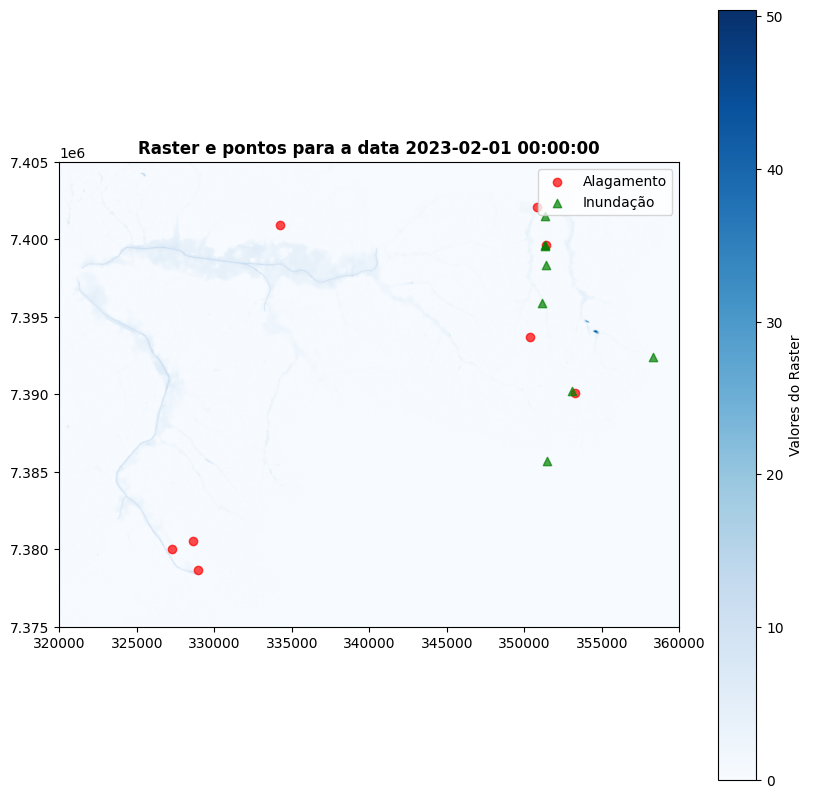

In [4]:
# Carregar o GeoDataFrame
gdf = gpd.read_file(gdf_file)

# Obter a data do pacote
package_date = extract_package_and_date(raster_file, packages_file)

# Defina os limites manualmente
xlim = (320000, 360000)  # Ajuste os limites do eixo X
ylim = (7.375e6, 7.405e6)  # Ajuste os limites do eixo Y

# Plotar raster e pontos
plot_raster_and_points(raster_file, gdf, package_date, xlim, ylim)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
from shapely.geometry import Point
from shapely.ops import unary_union
from rasterio.mask import mask
from matplotlib.patches import Polygon as mpl_Polygon
import matplotlib.patches as mpatches

In [6]:
def get_max_raster_value_within_buffer(buffer, raster_file, transform):
    # Ler o raster
    with rasterio.open(raster_file) as src:
        # Obter a máscara do raster dentro do buffer
        raster_data, _ = mask(src, [buffer], crop=True)
        
        # Verificar se há dados válidos no raster
        if raster_data.size == 0:
            return np.nan
        
        # Retornar o valor máximo dentro do buffer
        return np.nanmax(raster_data)


def plot_raster_and_points2(raster_file, gdf, package_date, xlim=None, ylim=None):
    # Ler o raster
    with rasterio.open(raster_file) as src:
        raster = src.read(1)
        transform = src.transform
    
    # Filtrar o GeoDataFrame pela data
    gdf['data'] = pd.to_datetime(gdf['data'])  # Garantir que a coluna 'data' seja datetime
    filtered_gdf = gdf[gdf['data'] == pd.to_datetime(package_date)]
    
    # Separar pontos por tipo de ocorrência
    alagamento_gdf = filtered_gdf[filtered_gdf['ocorrencia'] == 'ALAGAMENTO']
    inundacao_gdf = filtered_gdf[filtered_gdf['ocorrencia'] == 'INUNDACAO']
    
    # Plotar o raster
    fig, ax = plt.subplots(figsize=(10, 10))
    raster_image = show(raster, transform=transform, ax=ax, cmap='Blues', title=f"Raster and data points for date: {package_date}")
    
    # Adicionar escala (colorbar) ao raster
    cbar = plt.colorbar(raster_image.get_images()[0], ax=ax, orientation='vertical')
    cbar.set_label('Raster values')
    
    # Plotar os pontos diferenciados
    alagamento_gdf.plot(ax=ax, color='red', marker='o', label='Flooding', alpha=0.7)
    inundacao_gdf.plot(ax=ax, color='green', marker='^', label='Inundation', alpha=0.7)
    
    # Ajustar os limites manualmente
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    # Adicionar buffers de diferentes tamanhos e calcular o valor máximo do raster
    buffer_sizes = [50, 100, 150]  # Tamanhos dos buffers em metros
    for _, point in filtered_gdf.iterrows():
        # Criar o ponto e gerar os buffers
        point_geom = Point(point.geometry.x, point.geometry.y)
        
        for size in buffer_sizes:
            buffer = point_geom.buffer(size)  # Criar buffer em metros
            
            # Obter o valor máximo dentro do buffer
            max_value = get_max_raster_value_within_buffer(buffer, raster_file, transform)
            
            # Plotar o buffer utilizando o matplotlib
            patch = mpl_Polygon(list(buffer.exterior.coords), edgecolor='black', facecolor='none', linestyle='--', linewidth=1)
            ax.add_patch(patch)
            
    # Adicionar legenda
    plt.legend()
    plt.savefig('flooding_validation_2.png')
    plt.show()


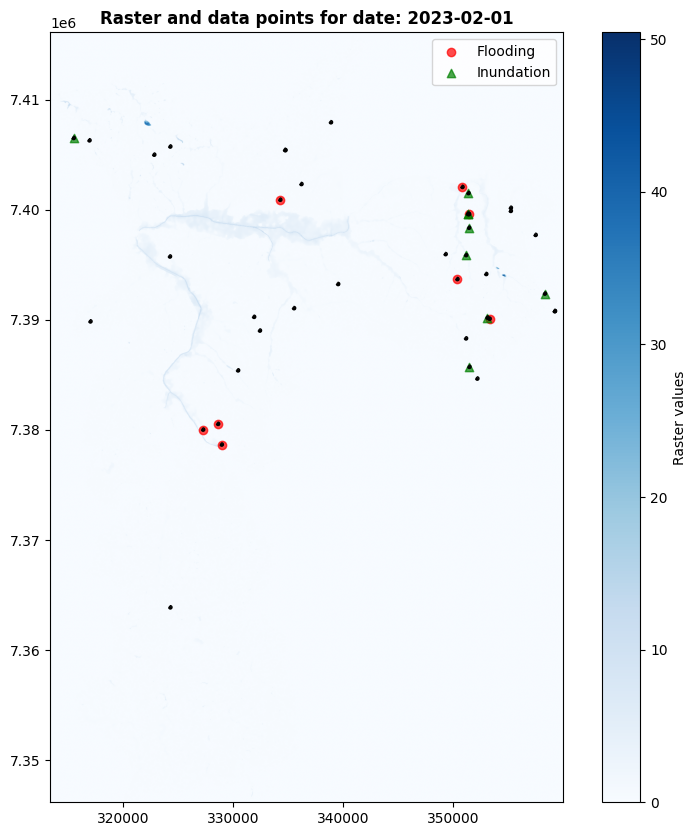

In [7]:
# Carregar o GeoDataFrame
gdf = gpd.read_file(gdf_file)

# Obter a data do pacote
package_date = "2023-02-01"  # Exemplo de data de pacote

# Criar o gráfico com limites manuais
plot_raster_and_points2(raster_file, gdf, package_date)

In [8]:
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.geometry import Point
from rasterio.mask import mask

def get_max_raster_value_within_buffer(buffer, raster_file, transform, crs):
    # Ler o raster
    with rasterio.open(raster_file) as src:
        # Obter a máscara do raster dentro do buffer
        raster_data, _ = mask(src, [buffer], crop=True)
        
        # Verificar se há dados válidos no raster
        if raster_data.size == 0:
            return None  # Retorna None se não houver dados válidos
        
        # Retornar o valor máximo dentro do buffer
        return raster_data.max()


def calculate_buffer_values(raster_file, gdf, package_date, buffer_sizes=[50, 100, 150]):
    # Verificar se o CRS do GeoDataFrame está definido
    if gdf.crs is None:
        # Defina um CRS padrão se necessário. Exemplo: EPSG:4326 (WGS 84)
        gdf.set_crs("EPSG:31983", allow_override=True, inplace=True)
    
    # Filtrar o GeoDataFrame pela data
    gdf['data'] = pd.to_datetime(gdf['data'])  # Garantir que a coluna 'data' seja datetime
    filtered_gdf = gdf[
        (gdf['data'] == pd.to_datetime(package_date)) & 
        (gdf['ocorrencia'].isin(['INUNDACAO', 'ALAGAMENTO']))
    ]
    
    # Inicializar a lista para armazenar os resultados
    results = []

    # Iterar sobre cada ponto no GeoDataFrame filtrado
    for _, point in filtered_gdf.iterrows():
        # Criar o ponto
        point_geom = Point(point.geometry.x, point.geometry.y)
        
        # Dicionário para armazenar os valores dos buffers
        buffer_values = {'ponto': point.geometry, 'data': package_date}
        
        # Calcular o valor máximo para cada buffer
        for size in buffer_sizes:
            buffer = point_geom.buffer(size)  # Criar buffer em metros
            max_value = get_max_raster_value_within_buffer(buffer, raster_file, transform=None, crs=gdf.crs)
            buffer_values[f'{size}m'] = max_value
        
        # Adicionar os resultados
        results.append(buffer_values)
    
    # Criar o DataFrame com os resultados
    results_df = pd.DataFrame(results)
    return results_df

In [9]:
# Carregar o GeoDataFrame
gdf = gpd.read_file(gdf_file)


# Obter a data do pacote
package_date = "2023-02-01"  # Exemplo de data de pacote

# Calcular os valores dos buffers e gerar a tabela
buffer_sizes = [15, 25, 50, 100, 200]
result_table = calculate_buffer_values(raster_file, gdf, package_date, buffer_sizes)

# Exibir a tabela
print(result_table)

# TODO Gerar uma curva de 10 em 10 metros

                                            ponto        data       15m  \
0     POINT (334269.7913694795 7400916.230352445)  2023-02-01  0.003131   
1      POINT (351422.44166636 7398375.3963587675)  2023-02-01  0.008020   
2     POINT (353288.7214289458 7390108.439041629)  2023-02-01  0.001125   
3     POINT (350820.9313081987 7402080.448349796)  2023-02-01  0.808137   
4    POINT (353084.74381733045 7390212.823735375)  2023-02-01  0.003042   
5    POINT (351366.4223829054 7401519.1796476925)  2023-02-01  0.000000   
6     POINT (315503.8288970126 7406528.464668743)  2023-02-01  0.001456   
7    POINT (351452.58416253945 7385738.889704838)  2023-02-01  0.000000   
8    POINT (350360.39155840117 7393708.581422271)  2023-02-01  0.012778   
9    POINT (358311.62264842825 7392391.097566412)  2023-02-01  0.000000   
10    POINT (351317.6766456178 7399647.223519541)  2023-02-01  0.010584   
11    POINT (351419.5787654092 7399619.142117798)  2023-02-01  0.000000   
12    POINT (351360.76268

In [12]:
result_table.to_csv('/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/Presentation Birmingham Feb 2025/resultados_Cassiano.csv', index=False)

In [112]:
result_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ponto   17 non-null     object 
 1   data    17 non-null     object 
 2   50m     17 non-null     float32
 3   100m    17 non-null     float32
 4   150m    17 non-null     float32
dtypes: float32(3), object(2)
memory usage: 608.0+ bytes


In [126]:
print(len(result_table[result_table['15m']>0.3])/len(result_table))
print(len(result_table[result_table['25m']>0.3])/len(result_table))
print(len(result_table[result_table['50m']>0.3])/len(result_table))
print(len(result_table[result_table['100m']>0.3])/len(result_table))
print(len(result_table[result_table['200m']>0.3])/len(result_table))

0.11764705882352941
0.23529411764705882
0.29411764705882354
0.7647058823529411
0.8235294117647058


In [122]:
len(result_table[result_table['15m']>0.3])/len(result_table)

0.11764705882352941